# Лабораторная 1. Очистка и подготовка датасета

ФИО: Фам Данг Чунг Нгиа

Группа: P3321

ISU: 374806

# Подключение модулей

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# Загрузка данных

В данной задаче у нас 7 признаков и 1 целевая переменная (Weekly_Sales). Целевая переменная представляет собой недельный объём продаж (Weekly_Sales), который необходимо предсказать на основе данных о магазине (Store), дате (Date), праздниках (Holiday_Flag), температуре (Temperature), цене топлива (Fuel_Price), индексе потребительских цен (CPI) и уровне безработицы (Unemployment).


In [2]:
df = pd.read_csv("/content/Walmart.csv")

In [3]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


# Описательная статистика

Данные содержат 6435 колон и 8 столбцов.

Ни один столбец не пропущен и не имеет мощность, равной 1.

In [ ]:
print(df.shape)

(6435, 8)


In [4]:
# количество столбцов и строк
C = len(df.columns)
L = len(df.index)

CN = df.count()                     # количество определенных значений
NP = ((L - CN) / L) * 100           # процент пропущенных значений
DT = df.dtypes.astype(str)          # data types

# вычислять статистику только для числовых столбцов
num_df = df.select_dtypes(include='number')

# Вычислять статистику только для столбцов
MN = num_df.min()                   # минимум
Q1 = num_df.quantile(q=0.25)        # первый квартиль
MA = num_df.mean()                  # среднее значение
ME = num_df.median()                # медиана
Q3 = num_df.quantile(q=0.75)        # третий квартиль
MX = num_df.max()                   # максимум
ST = num_df.std()                   # стандартное отклонение
P  = df.nunique()                   # мощность
IQ = Q3 - Q1                        # интерквартильный размах (IQR)


In [5]:
frame = pd.concat([DT, CN, NP, MN, Q1, MA, ME, Q3, MX, ST, P, IQ], axis=1, join="outer") # "inner" if not want "Date"
frame=frame.T
f=pd.DataFrame(frame)
f.index=['Тип данных', 'Количество', 'Процент пропусков', 'Минимум', 'Первый квартиль','Среднее', 'Медиана', 'Третий квартиль', 'Максимум','Стандартное отклонение', 'Мощность', 'Интерквартильный размах']
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
f1=f.style.apply(lambda x: ["background-color:tomato" if i==1 else "" for i in x], axis=1, subset=(["Мощность"], slice(None))).apply(lambda x: ["background-color:tomato" if i>=60 else "" for i in x], axis=1, subset=(["Процент пропусков"], slice(None))).apply(lambda x: ["background-color:steelblue" if (i<30 and i>0) else "" for i in x], axis=1, subset=(["Процент пропусков"], slice(None))).apply(lambda x: ["background-color:limegreen" if i==0 else "" for i in x], axis=1, subset=(["Процент пропусков"], slice(None)))
f1

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Тип данных,int64,object,float64,int64,float64,float64,float64,float64
Количество,6435,6435,6435,6435,6435,6435,6435,6435
Процент пропусков,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Минимум,1.000000,nan,209986.250000,0.000000,-2.060000,2.472000,126.064000,3.879000
Первый квартиль,12.000000,nan,553350.105000,0.000000,47.460000,2.933000,131.735000,6.891000
Среднее,23.000000,nan,1046964.877562,0.069930,60.663782,3.358607,171.578394,7.999151
Медиана,23.000000,nan,960746.040000,0.000000,62.670000,3.445000,182.616521,7.874000
Третий квартиль,34.000000,nan,1420158.660000,0.000000,74.940000,3.735000,212.743293,8.622000
Максимум,45.000000,nan,3818686.450000,1.000000,100.140000,4.468000,227.232807,14.313000
Стандартное отклонение,12.988182,nan,564366.622054,0.255049,18.444933,0.459020,39.356712,1.875885


# Обработка данных

## 1. Заполнение пропусков
Нет пропусков в данных

## 2. Удаление выбросов

*   Unemployment имеет наибольшее количество выбросов (7,47% от выборки), что указывает на значительные различия между регионами.

*   Weekly_Sales имеет 0,53% выбросов от выборки, возможно, это связано со специальной неделей (Holiday_Flag = 1).

*   Temperature имеет несколько выбросов (0,05%).
*   Store, Fuel_Price и CPI не имеют выбросов, все значения находятся в разумных пределах.

Столбцы, требующие удаления выбросов, - это Unemployment и Temperature, а
Weekly_Sales не нуждается в обработке из-за сезонных факторов (Holiday_Flag) (и она еще целевая переменная).

In [6]:
# Выбрать допустимый числовой столбец для просмотра выбросов
numeric_candidates = num_df.columns.tolist()
binary_like = [c for c in numeric_candidates if df[c].nunique() <= 2]  # Нельзя типа двоичного столбца (Holiday_Flag)
num_for_outlier = [c for c in numeric_candidates if c not in binary_like]

# Рассчитать нижний/верхний порог в соответствии с IQR
lower = Q1[num_for_outlier] - 1.5 * IQ[num_for_outlier]
upper = Q3[num_for_outlier] + 1.5 * IQ[num_for_outlier]

# Подсчитать количество выбросов и их процентов для каждого столбца
outlier_counts = {}
outlier_percents = {}

for c in num_for_outlier:
    mask_low  = df[c] < lower[c]
    mask_high = df[c] > upper[c]
    cnt = (mask_low | mask_high).sum()
    outlier_counts[c] = cnt                       # количество выбросов
    outlier_percents[c] = 100.0 * cnt / len(df)   # их процентов

# Создать таблицу
outlier_summary = pd.DataFrame({
    'Q1': Q1[num_for_outlier],
    'Q3': Q3[num_for_outlier],
    'IQR': IQ[num_for_outlier],
    'Lower_bound': lower,
    'Upper_bound': upper,
    'Min': MN[num_for_outlier],
    'Max': MX[num_for_outlier],
    'Outliers_count': pd.Series(outlier_counts),
    'Outliers_percent': pd.Series(outlier_percents),
})
outlier_summary['Has_outliers'] = outlier_summary['Outliers_count'] > 0

# Смотреть таблицу
outlier_summary.sort_values('Outliers_percent', ascending=False).T


,Unemployment,Weekly_Sales,Temperature,Store,Fuel_Price,CPI
Q1,6.891,553350.105,47.46,12.0,2.933,131.735
Q3,8.622,1420158.66,74.94,34.0,3.735,212.743293
IQR,1.731,866808.555,27.48,22.0,0.802,81.008293
Lower_bound,4.2945,-746862.7275,6.24,-21.0,1.73,10.22256
Upper_bound,11.2185,2720371.4925,116.16,67.0,4.938,334.255734
Min,3.879,209986.25,-2.06,1.0,2.472,126.064
Max,14.313,3818686.45,100.14,45.0,4.468,227.232807
Outliers_count,481,34,3,0,0,0
Outliers_percent,7.474747,0.528361,0.04662,0.0,0.0,0.0
Has_outliers,True,True,True,False,False,False


Удалили выбросы

In [7]:
df_clean = df.copy()

# Список столбцов, по которым удаляем выбросы
cols_to_filter = ['Unemployment', 'Temperature']

# Подсчёт выбросов по каждому столбцу (для отчёта)
removed_per_col = {}

# Формируем итоговую маску "строки оставить" (изначально True для всех строк)
mask_keep = pd.Series(True, index=df_clean.index)

for c in cols_to_filter:
    lo = lower[c]
    hi = upper[c]

    mask_c = df_clean[c].between(lo, hi, inclusive='both')
    removed_per_col[c] = (~mask_c).sum()

    mask_keep &= mask_c

# Применяем маску: удаляем строки-выбросы (хотя бы по одному из столбцов)
n_before = len(df_clean)
df_clean = df_clean[mask_keep].reset_index(drop=True)
n_after  = len(df_clean)
n_removed_total = n_before - n_after

print("✅ Успешно удалили выбросы по IQR.")
print(f"Строк было: {n_before}  |  Осталось: {n_after}  |  Удалено всего: {n_removed_total}")

# Краткий отчёт по каждому столбцу
report = pd.DataFrame({
    'Removed_rows_per_column': pd.Series(removed_per_col)
}).sort_values('Removed_rows_per_column', ascending=False)

print("\nСтрок удалено по каждому столбцу (до объединения условий):")
print(report)

# Проверка диапазонов после очистки
check_clean = pd.DataFrame({
    'Lower_bound': lower[cols_to_filter],
    'Min_after_clean': df_clean[cols_to_filter].min(),
    'Max_after_clean': df_clean[cols_to_filter].max(),
    'Upper_bound': upper[cols_to_filter]
}).T

print("\nПроверка границ после очистки:")
check_clean


✅ Успешно удалили выбросы по IQR.
Строк было: 6435  |  Осталось: 5951  |  Удалено всего: 484

Строк удалено по каждому столбцу (до объединения условий):
              Removed_rows_per_column
Unemployment                      481
Temperature                         3

Проверка границ после очистки:


,Unemployment,Temperature
Lower_bound,4.2945,6.24
Min_after_clean,4.3080,7.46
Max_after_clean,10.9260,100.14
Upper_bound,11.2185,116.16


In [ ]:
df_clean.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


## 3. Согласовать типы данных

In [8]:
df_typed = df_clean.copy();

# Date → datetime64[ns]
s = df_clean['Date'].astype(str)
df_typed['Date'] = pd.to_datetime(s, format='%d-%m-%Y', errors='coerce')

# Holiday_Flag → binary 0/1 (int8)
df_typed['Holiday_Flag'] = df_clean['Holiday_Flag'].astype('int8')

# Store → Int16 (оптимизация памяти)
df_typed['Store'] = pd.to_numeric(df_clean['Store'], errors='coerce').astype('Int16')

# остальные столбцы → float64
for c in ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']:
    if c in df_clean.columns:
        df_typed[c] = pd.to_numeric(df_clean[c], errors='coerce').astype('float64')

print("✅ Соласовали типы данных:")
print(df_typed.dtypes)

# Проверить ошибки
print("\nСтолбцы, у которых проблемы с преобразованием типы данных (количество сломанных столбцов -NaN/NaT):\n")
for col in df_typed.columns:
    missing = df_typed[col].isna().sum()
    if missing > 0:
        total = len(df_typed)
        percent = (missing / total) * 100
        print(f"{col:<15}: {missing:>5} ({percent:.2f}%)")

✅ Соласовали типы данных:
Store                    Int16
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag              int8
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object

Столбцы, у которых проблемы с преобразованием типы данных (количество сломанных столбцов -NaN/NaT):



In [ ]:
df_typed.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


## 4. Проектирование признаков


### 4.1 Признаки на основе даты

In [9]:
df_fe = df_typed.copy()
df_fe = df_fe.sort_values(['Store', 'Date']).reset_index(drop=True)

In [10]:
# Разделение основных временных составляющих
df_fe['Year']        = df_fe['Date'].dt.year
df_fe['Month']       = df_fe['Date'].dt.month
df_fe['Day']         = df_fe['Date'].dt.day
df_fe['Quarter']     = df_fe['Date'].dt.quarter
df_fe['DayOfWeek']   = df_fe['Date'].dt.dayofweek              # 0=Mon..6=Sun
df_fe['WeekOfYear']  = df_fe['Date'].dt.isocalendar().week.astype('int16')

# Флажок обозначает начало/конец цикла
df_fe['IsMonthStart'] = df_fe['Date'].dt.is_month_start.astype('int8')
df_fe['IsMonthEnd']   = df_fe['Date'].dt.is_month_end.astype('int8')
df_fe['IsQuarterStart'] = df_fe['Date'].dt.is_quarter_start.astype('int8')
df_fe['IsQuarterEnd']   = df_fe['Date'].dt.is_quarter_end.astype('int8')

# SEASON: 1:Winter,2:Spring,3:Summer,4:Autumn ---
df_fe['Season'] = pd.cut(
    df_fe['Month'],
    bins=[0,3,6,9,12],
    labels=[1,2,3,4],  # 1=Winter,2=Spring,3=Summer,4=Autumn
    include_lowest=True
).astype('int8')


In [11]:
df_fe.head(5)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,Quarter,DayOfWeek,WeekOfYear,IsMonthStart,IsMonthEnd,IsQuarterStart,IsQuarterEnd,Season
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5,1,4,5,0,0,0,0,1
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,12,1,4,6,0,0,0,0,1
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,19,1,4,7,0,0,0,0,1
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,26,1,4,8,0,0,0,0,1
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,5,1,4,9,0,0,0,0,1


График для проверки

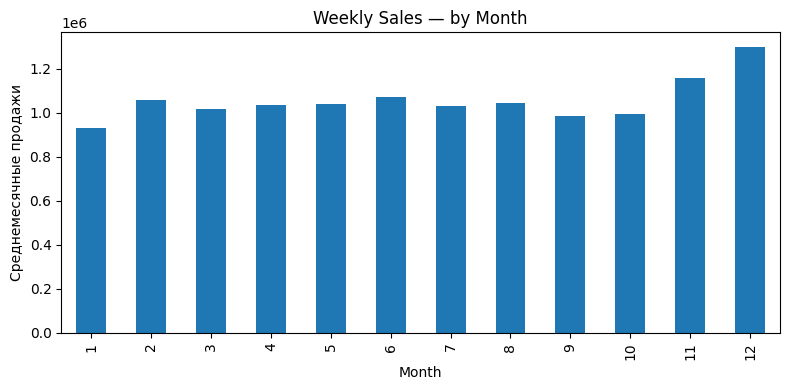

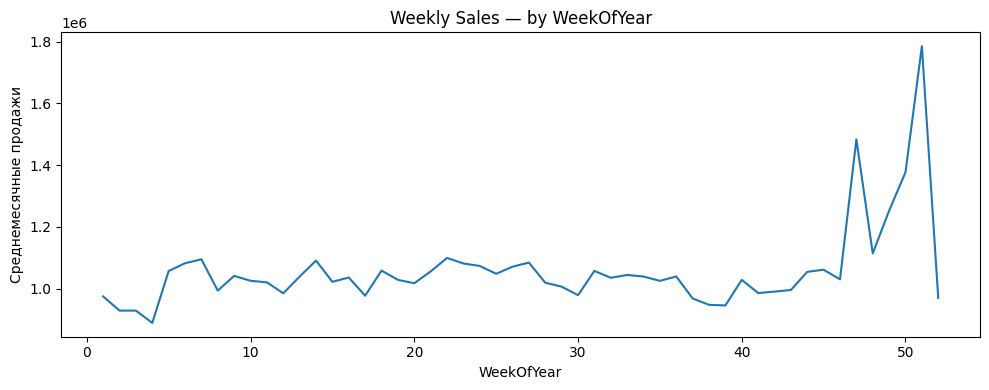

In [12]:
import matplotlib.pyplot as plt

# Graphic Weekly_sales by Month
month_order = list(range(1,13))
month_mean = (df_fe
              .groupby('Month')['Weekly_Sales']
              .mean()
              .reindex(month_order))

plt.figure(figsize=(8,4))
month_mean.plot(kind='bar')
plt.title('Weekly Sales — by Month')
plt.xlabel('Month')
plt.ylabel('Среднемесячные продажи')
plt.tight_layout()
plt.show()

# Graphic Weekly_sales by WeekOfYear
weeks = sorted(df_fe['WeekOfYear'].dropna().unique())
week_mean = (df_fe
             .groupby('WeekOfYear')['Weekly_Sales']
             .mean()
             .reindex(weeks))

plt.figure(figsize=(10,4))
week_mean.plot()
plt.title('Weekly Sales — by WeekOfYear')
plt.xlabel('WeekOfYear')
plt.ylabel('Среднемесячные продажи')
plt.tight_layout()
plt.show()



### 4.2 Лаггирование (предыдущие периоды)

In [13]:
df_lag = df_fe.copy()
for L in [1, 2, 4, 52]:
    df_lag[f'Weekly_Sales_lag{L}'] = df_lag.groupby('Store')['Weekly_Sales'].shift(L)


In [14]:
df_lag[['Store', 'Date', 'Weekly_Sales', 'Weekly_Sales_lag1', 'Weekly_Sales_lag2', 'Weekly_Sales_lag4', 'Weekly_Sales_lag52']].head(10)

,Store,Date,Weekly_Sales,Weekly_Sales_lag1,Weekly_Sales_lag2,Weekly_Sales_lag4,Weekly_Sales_lag52
0,1,2010-02-05,1643690.90,NaN,NaN,NaN,NaN
1,1,2010-02-12,1641957.44,1643690.90,NaN,NaN,NaN
2,1,2010-02-19,1611968.17,1641957.44,1643690.90,NaN,NaN
3,1,2010-02-26,1409727.59,1611968.17,1641957.44,NaN,NaN
4,1,2010-03-05,1554806.68,1409727.59,1611968.17,1643690.90,NaN
5,1,2010-03-12,1439541.59,1554806.68,1409727.59,1641957.44,NaN
6,1,2010-03-19,1472515.79,1439541.59,1554806.68,1611968.17,NaN
7,1,2010-03-26,1404429.92,1472515.79,1439541.59,1409727.59,NaN
8,1,2010-04-02,1594968.28,1404429.92,1472515.79,1554806.68,NaN
9,1,2010-04-09,1545418.53,1594968.28,1404429.92,1439541.59,NaN


### 4.3 Агрегации

In [15]:
df_ag = df_lag.copy()
df_ag = df_ag.sort_values(['Store', 'Date']).reset_index(drop=True)

In [16]:
# Среднее скользящее значение и стандартное отклонение за 4 недели (только за прошлые периоды)
df_ag['WS_roll4_mean'] = (
    df_ag.groupby('Store')['Weekly_Sales']
         .transform(lambda s: s.shift(1).rolling(4, min_periods=2).mean())
)

df_ag['WS_roll4_std'] = (
    df_ag.groupby('Store')['Weekly_Sales']
         .transform(lambda s: s.shift(1).rolling(4, min_periods=2).std())
)

# Среднее значение, накопленное по Store
df_ag['Store_cum_mean'] = (
    df_ag.groupby('Store')['Weekly_Sales']
         .transform(lambda s: s.shift(1).expanding().mean())
)

# Среднее значение по Store и WeekOfYear
df_ag['Store_Week_hist_mean'] = (
    df_ag.groupby(['Store','WeekOfYear'])['Weekly_Sales']
         .transform(lambda s: s.shift(1).expanding().mean())
)

In [17]:
base = ['Store', 'Date', 'Weekly_Sales']
fe_cols = ['WS_roll4_mean','WS_roll4_std','Store_cum_mean','Store_Week_hist_mean']
df_ag = df_ag.dropna(subset=fe_cols).reset_index(drop=True)

print("Количество строк после создания aggregation features:", df_ag.shape[0])

df_ag[base + fe_cols].head(10)

Количество строк после создания aggregation features: 3716


,Store,Date,Weekly_Sales,WS_roll4_mean,WS_roll4_std,Store_cum_mean,Store_Week_hist_mean
0,1,2011-02-04,1606629.58,1.370013e+06,59611.187606,1.514594e+06,1643690.90
1,1,2011-02-11,1649614.93,1.410487e+06,134799.005474,1.516330e+06,1641957.44
2,1,2011-02-18,1686842.78,1.475137e+06,177573.114442,1.518799e+06,1611968.17
3,1,2011-02-25,1456800.28,1.564997e+06,168614.277452,1.521854e+06,1409727.59
4,1,2011-03-04,1636263.41,1.599972e+06,100918.147849,1.520692e+06,1554806.68
5,1,2011-03-11,1553191.63,1.607380e+06,102642.788617,1.522720e+06,1439541.59
6,1,2011-03-18,1576818.06,1.583275e+06,100722.259369,1.523245e+06,1472515.79
7,1,2011-03-25,1541102.38,1.555768e+06,74663.385362,1.524153e+06,1404429.92
8,1,2011-04-01,1495064.75,1.576844e+06,42298.798109,1.524436e+06,1594968.28
9,1,2011-04-08,1614259.35,1.541544e+06,34353.273993,1.523954e+06,1545418.53


## Масштабирование числовых признаков

In [18]:
from sklearn.preprocessing import MinMaxScaler

df_scaled = df_ag.copy()

num_cols = df_scaled.select_dtypes(include=['float64', 'int64', 'Int16']).columns
num_cols = [c for c in num_cols if c not in ['Store', 'Holiday_Flag']]

scaler = MinMaxScaler()
df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])

print("✅ Масштабировали числовую характеристику на интервал [0,1]")
df_scaled[num_cols].head()


✅ Масштабировали числовую характеристику на интервал [0,1]


,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,WeekOfYear,Weekly_Sales_lag1,Weekly_Sales_lag2,Weekly_Sales_lag4,Weekly_Sales_lag52,WS_roll4_mean,WS_roll4_std,Store_cum_mean,Store_Week_hist_mean
0,0.401982,0.375877,0.010040,0.852623,0.542239,0.078431,0.318269,0.321305,0.355204,0.397291,0.442913,0.067270,0.660387,0.397291
1,0.414401,0.312385,0.032129,0.856340,0.542239,0.098039,0.401982,0.318269,0.339684,0.396811,0.458784,0.154510,0.661299,0.396811
2,0.425158,0.538819,0.047523,0.859467,0.542239,0.117647,0.414401,0.401982,0.321305,0.388501,0.484133,0.204140,0.662595,0.388501
3,0.358691,0.598639,0.060910,0.862358,0.542239,0.137255,0.425158,0.414401,0.318269,0.332458,0.519367,0.193745,0.664200,0.332458
4,0.410544,0.562790,0.210174,0.865249,0.542239,0.156863,0.358691,0.425158,0.401982,0.372661,0.533081,0.115198,0.663590,0.372661


In [19]:
df_scaled[num_cols].describe().T[['min', 'max', 'mean', 'std']]

,min,max,mean,std
Weekly_Sales,0.0,1.0,0.240726,0.164204
Temperature,0.0,1.0,0.584564,0.192685
Fuel_Price,0.0,1.0,0.439107,0.180434
CPI,0.0,1.0,0.502969,0.396330
Unemployment,0.0,1.0,0.499697,0.192193
WeekOfYear,0.0,1.0,0.480039,0.266753
Weekly_Sales_lag1,0.0,1.0,0.240327,0.164077
Weekly_Sales_lag2,0.0,1.0,0.239808,0.163811
Weekly_Sales_lag4,0.0,1.0,0.238913,0.163354
Weekly_Sales_lag52,0.0,1.0,0.229765,0.157113


## Кодирование категориальных признаков

В разделе «Кодирование категориальных признаков» было отмечено, что все категориальные переменные (Store, Holiday_Flag, Month, Quarter, DayOfWeek, Season) уже представлены в числовом виде.
Поэтому дополнительное кодирование (Label Encoding или One-Hot Encoding) не требовалось.

# Выводы

В ходе лабораторной работы №1 была проведена полная очистка и подготовка датасета Walmart.

На основе анализа и обработки данных были выполнены следующие шаги:

1. **Заполнение и удаление пропусков** — проверены отсутствующие значения, выявлено, что пропусков нет.
2. **Удаление выбросов** — с помощью метода IQR удалены аномальные значения по показателям *Unemployment*, *Temperature*.
3. **Согласование типов данных** — все числовые признаки приведены к корректным типам (`int`, `float`), дата преобразована в формат `datetime64[ns]`.
4. **Проектирование признаков** — созданы новые признаки на основе даты (год, месяц, день, неделя года, сезон и др.), лаги продаж (`Weekly_Sales_lag1`, `lag2`, `lag4`, `lag52`) и агрегированные признаки (rolling и cumulative mean).
5. **Масштабирование числовых признаков** — числовые данные приведены к единой шкале методом MinMax normalization.
6. **Кодирование категориальных признаков** — не выполнялось, так как все категориальные данные уже имели числовое представление.

Проведённая обработка обеспечила чистоту, согласованность и готовность данных для последующего этапа — построения моделей анализа и прогнозирования продаж.

# Save prepared dataset for the second lab

In [22]:
df_final = df_scaled.copy()

# Return original values of column Weekly_Sales
df_final['Weekly_Sales'] = df_ag['Weekly_Sales'].values

print(df_final.shape)
print(df_final.head())

(3716, 27)
   Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1 2011-02-04    1606629.58             0     0.375877    0.010040   
1      1 2011-02-11    1649614.93             1     0.312385    0.032129   
2      1 2011-02-18    1686842.78             0     0.538819    0.047523   
3      1 2011-02-25    1456800.28             0     0.598639    0.060910   
4      1 2011-03-04    1636263.41             0     0.562790    0.210174   

        CPI  Unemployment  Year  Month  Day  Quarter  DayOfWeek  WeekOfYear  \
0  0.852623      0.542239  2011      2    4        1          4    0.078431   
1  0.856340      0.542239  2011      2   11        1          4    0.098039   
2  0.859467      0.542239  2011      2   18        1          4    0.117647   
3  0.862358      0.542239  2011      2   25        1          4    0.137255   
4  0.865249      0.542239  2011      3    4        1          4    0.156863   

   IsMonthStart  IsMonthEnd  IsQuarterStart  IsQuarterEnd

In [23]:
output_path = "walmart_prepared_lab1.csv"
df_final.to_csv(output_path, index=False)

print("Saved cleaned & engineered dataset to:", output_path)


Saved cleaned & engineered dataset to: walmart_prepared_lab1.csv
